# TODO:
 1. Create (small) Dataset for comparison of different data imputation techniques
 2. Run several imputation methods
 3. Compare them in time and accuracy
 4. Write first chapter of thesis!

Imputation techniques:
* mean / median
* k-NN
* MICE
* Maybe some additional methods at a later point


In [4]:
import sys
import os
import time

import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#from sklearn.experimental import enable_iterative_imputer   #line needed because something is deprecated
from sklearn import linear_model

from IPython.core.display_functions import display

#from NDBC_Buoy_Data import myLibrary as mL
dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import myLibrary as mL

NDBC = mL.NDBC_lib

----

# Build Dataset

Find station and year with lowest num of NaN values!

In [5]:
stations = NDBC.stations_GOM
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020" "2021", "2022"]

NaN_statistic = pd.DataFrame()
for year in years:
    for stationID in NDBC.cleaned_stations_GOM:
        data = NDBC.get_data_file(stationID, year)
        if data is not None:
            data = NDBC.df_modification(data)[1]
            data = NDBC.replace_with_NaN(data)
            num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(data, "", silent=True)

            new_row = pd.DataFrame({
                    "StationID": [stationID],
                    "Year": [year],
                    "#NaN in %": [num_NaN_percentage]
                })
            NaN_statistic = pd.concat([NaN_statistic, new_row])

Failed to get file: HTTP Error 404: Not Found
from web
from web
from web
from web
from web
from web
from web
Failed to get file: HTTP Error 404: Not Found
from web
Failed to get file: HTTP Error 404: Not Found
from web
from web
from web
from web
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
from web
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to

In [6]:
NaN_statistic

,StationID,Year,#NaN in %
0,41112,2010,61.86
0,42001,2010,54.82
0,42002,2010,39.09
0,42012,2010,17.21
0,42013,2010,81.65
...,...,...,...
0,42055,2022,56.78
0,42095,2022,55.18
0,42097,2022,62.14
0,42098,2022,63.14


As we can see, the dataset of station 42001 of the year 2016 includes the lowest amount of NaN values, so lets continue with that file.

In [7]:
test_data = NDBC.get_data_file("42001", "2016")
test_data = NDBC.df_modification(test_data)[1]
test_data = NDBC.replace_with_NaN(test_data)
test_data

from disc


,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001,VIS_42001,TIDE_42001
timestamp,,,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2,NaN,NaN
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2,NaN,NaN
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0,NaN,NaN
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1,NaN,NaN
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9,NaN,NaN
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0,NaN,NaN
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5,NaN,NaN


<AxesSubplot:>

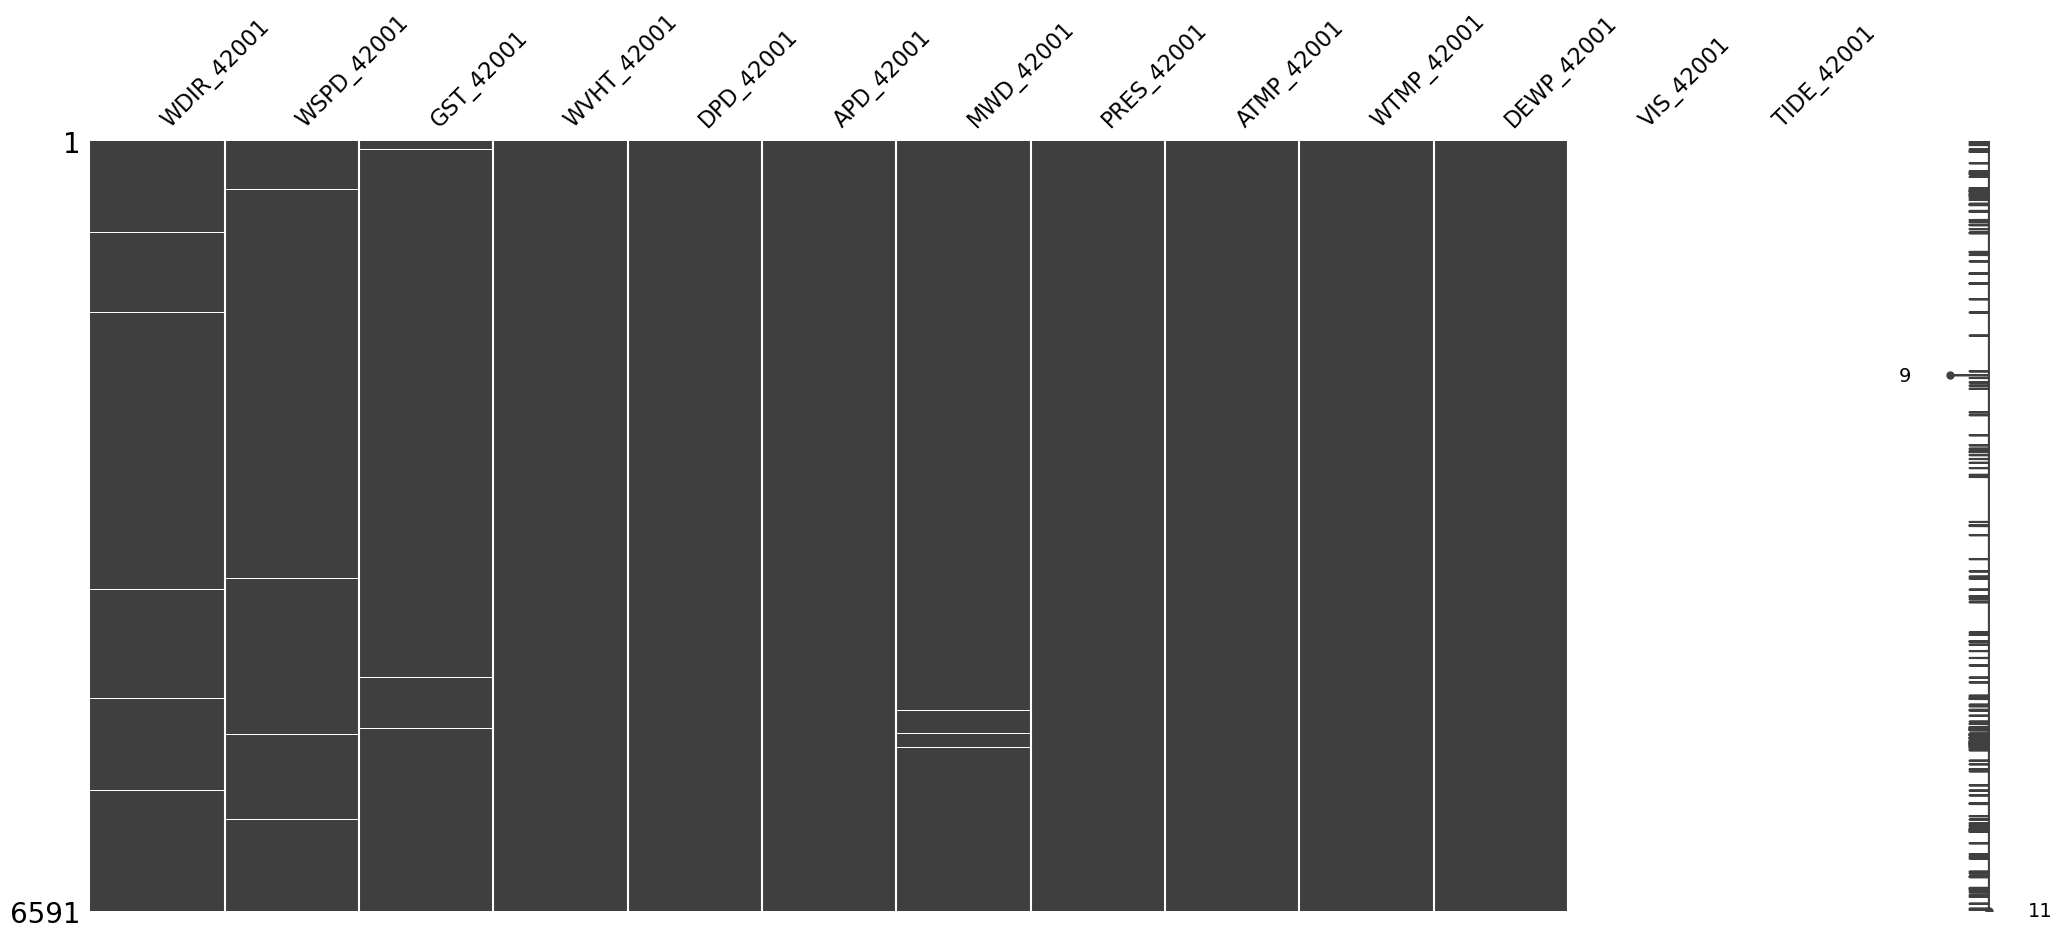

In [8]:
msno.matrix(test_data)

The graph shows that the features VIS and TIDE do not provide any values, so lets those colums without any values!

In [9]:
#test_data = NDBC.drop_NaN_rows_and_cols(test_data) #ORIGINAL!
test_data = test_data.dropna(axis=1, how='all')  # drop cols if all values are NaN  #ATTENTION: CODE CHANGED WITHOUT EXECUTION!!!!
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0


In [10]:
num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(test_data, "") #unneeded


 
number of values:  72501
number of NaN values:  175 ( 0.24 %)



In [11]:
NaN_by_feature

,Feature,#NaN,%NaN
0,WDIR_42001,49,0.74
1,WSPD_42001,22,0.33
2,GST_42001,38,0.58
3,WVHT_42001,0,0.00
4,DPD_42001,0,0.00
5,APD_42001,0,0.00
6,MWD_42001,66,1.00
7,PRES_42001,0,0.00
8,ATMP_42001,0,0.00
9,WTMP_42001,0,0.00


We do still have some NaN values ... now we delete those rows!

In [12]:
test_data = test_data.dropna(axis=0, how="any")  # drop rows if any values is NaN
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5


In [13]:
NDBC.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

--> All NaN values have successfully been removed. That means a "ground truth" dataset has successfully been created!

In [15]:
test_data.to_pickle("../data/NaN_ground_truth.pickle")

---

# Prepare evaluation
- exchange x% of the values at a random positon with NaN

In [16]:
test_data = pd.read_pickle("../data/NaN_ground_truth.pickle").astype(float)

In [17]:
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115.0,9.2,10.8,1.19,5.00,3.98,93.0,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114.0,7.1,8.5,1.17,5.56,4.47,95.0,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116.0,7.8,9.0,1.20,5.56,4.48,102.0,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116.0,7.4,8.5,1.24,6.25,4.56,94.0,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118.0,7.7,9.0,1.28,5.88,4.73,95.0,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166.0,9.2,11.3,1.52,6.67,4.81,76.0,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155.0,9.3,11.1,1.68,5.56,4.93,138.0,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161.0,9.2,10.5,1.58,6.25,4.90,100.0,1014.4,24.5,24.8,19.5


In [18]:
NDBC.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

# Data normalization

In [19]:
scaler = MinMaxScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
0,0.317549,0.621622,0.563158,0.268571,0.146277,0.192771,0.256267,0.376068,0.386555,0.055556,0.73125
1,0.314763,0.479730,0.442105,0.262857,0.176064,0.291165,0.261838,0.388889,0.394958,0.055556,0.73125
2,0.320334,0.527027,0.468421,0.271429,0.176064,0.293173,0.281337,0.397436,0.394958,0.055556,0.71875
3,0.320334,0.500000,0.442105,0.282857,0.212766,0.309237,0.259053,0.427350,0.403361,0.055556,0.72500
4,0.325905,0.520270,0.468421,0.294286,0.193085,0.343373,0.261838,0.448718,0.420168,0.055556,0.71875


## TODO:

- Evaluate data imputation techniques depending on % of NaN values in the perspective of execution time (clock time or CPU time?) and accuracy
- Also consider executing it on Google Colab for better comparability than using M1 chip!

----
# Data Imputation Techniques:

All functions should take a dataframe with NaN values as input and return a dataframe with the imputed values. Those methods must be useable as a parameter for the evaluation function!

In [20]:
def imputation_mean(data):
    return data.fillna(data.mean()) #replace all NaN values with the column-mean

In [21]:
def imputation_median(data):
    return data.fillna(data.median()) #replace all NaN values with the column-median

In [22]:
def imputation_knn(k):
    def imputation(data):
        imputer_knn = KNNImputer(n_neighbors=k, weights='uniform', metric='nan_euclidean')
        return pd.DataFrame(imputer_knn.fit_transform(data),columns = data.columns)
    return imputation

In [23]:
def imputation_mice(data):
    # Define MICE Imputer
    imputer_mice = IterativeImputer(
        estimator=linear_model.BayesianRidge(),
        n_nearest_features=None,
        imputation_order='ascending',
        max_iter=30,
        verbose=0)

    imputer_mice.fit(data)   #fit imputer on the dataset
    imputed_data = pd.DataFrame(imputer_mice.transform(data)) #transform the dataset #What exactly happens here?
    imputed_data.columns=data.columns
    return imputed_data

    #ISSUE: Column name and index got lost!

----
# Evaluation:

As Accuracy I use MSE (=Mean Square Error) since it is also used in the paper about DataWig. I need some arguments why this is correct / figure out if it even is the best way to measure the accuracy.

In [24]:
#This function can be used to evaluate the performance (time and accuracy) of a certain imputation technique on a certain dataset (=dataframe) and a certain NaN_rate
def evaluate(imputation, df_ground_truth, NaN_rate):
    df_NaN = df_ground_truth.mask(np.random.random(df_ground_truth.shape) < NaN_rate)   #NaN rate 10% = .1

    start_time = time.time()

    df_imputated = imputation(df_NaN)

    end_time = time.time()
    exec_time = end_time - start_time

    #Convert dataframes to list (needed to calc. mse)
    gt_list = list()
    imp_list = list()
    for gt_column, imp_column in zip(df_ground_truth, df_imputated):
        gt_list += df_ground_truth[gt_column].tolist()
        imp_list += df_imputated[imp_column].tolist()

    mse = mean_squared_error(gt_list, imp_list, squared=False)
    return mse, exec_time

In [25]:
evaluate(imputation_mean, test_data, NaN_rate=.1)

(0.0531637392539168, 0.003835916519165039)

In [26]:
evaluate(imputation_knn(5), test_data, NaN_rate=.1)

(0.0232638772169026, 1.5906269550323486)

In [27]:
#TODO:
def multiple_evaluation(imp_function, df_ground_truth):
    NaN_rates = np.arange(0, .6, .05)

    statistic = pd.DataFrame(columns=["%NaN", "MSE", "Exec Time"])
    for NaN_rate in NaN_rates:
        mse, exec_time = evaluate(imp_function, df_ground_truth, NaN_rate)

        #create statistic
        new_row = pd.DataFrame({
                    "%NaN": [NaN_rate],
                    "MSE": [mse],
                    "Exec Time": [exec_time]
                })
        statistic = pd.concat([statistic, new_row])

    return statistic


multiple_evaluation(imputation_mean, test_data)

,%NaN,MSE,Exec Time
0,0.00,0.000000,0.003989
0,0.05,0.037831,0.001764
0,0.10,0.053152,0.009373
0,0.15,0.065574,0.002107
0,0.20,0.075743,0.002594
0,0.25,0.085310,0.001906
0,0.30,0.094002,0.003135
0,0.35,0.100748,0.005944
0,0.40,0.107948,0.001841
0,0.45,0.114704,0.008185


In [28]:
def visualize_evaluation(imputation_techniques):
    imp_tech_names =[]
    mse_statistic = pd.DataFrame()
    time_statistic = pd.DataFrame()

    for imp_technique in imputation_techniques:
        statistic = multiple_evaluation(imp_technique[0], test_data)
        mse_statistic[imp_technique[1]] = statistic["MSE"]
        time_statistic[imp_technique[1]] = statistic["Exec Time"]
        imp_tech_names.append(imp_technique[1])

    mse_statistic.index = statistic["%NaN"]
    time_statistic.index = statistic["%NaN"]

    # visualize
    display(mse_statistic)
    display(time_statistic)

    mse_statistic.plot( y=imp_tech_names,
                    title="Data Imputation MSE",
                )

    time_statistic.plot( y=imp_tech_names,
                    title="Data Imputation Execution Time"
                )
    return mse_statistic, time_statistic

,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.000000,0.000000,0.000000
0.05,0.038955,0.038188,0.014593
0.10,0.054578,0.055631,0.023345
0.15,0.066366,0.066549,0.031858
0.20,0.075649,0.076558,0.041681
0.25,0.085809,0.087498,0.058110
0.30,0.092859,0.094163,0.071812
0.35,0.100014,0.103053,0.086283
0.40,0.108458,0.110456,0.098364


,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.003236,0.002137,0.001216
0.05,0.002617,0.002577,1.406154
0.10,0.002774,0.006819,1.444358
0.15,0.003347,0.003063,2.048654
0.20,0.005028,0.002599,2.662533
0.25,0.001840,0.004098,2.645614
0.30,0.003732,0.002889,2.694906
0.35,0.003263,0.004888,3.020156
0.40,0.005698,0.008072,3.699368


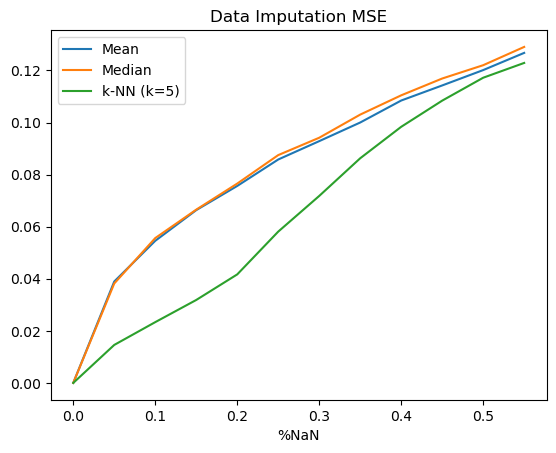

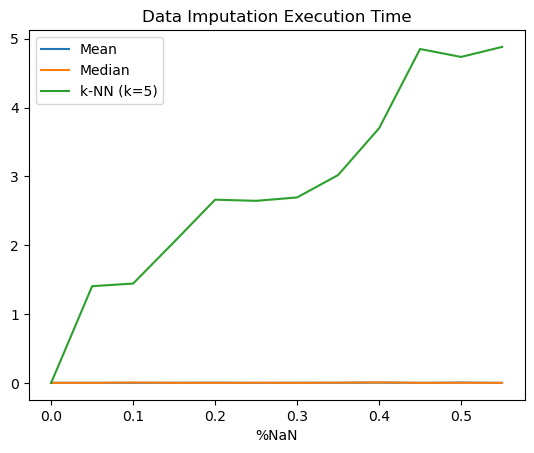

In [29]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(5), "k-NN (k=5)"),
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.038661,0.037946,0.018034,0.014102,0.016712,0.021147,0.022356,0.024585
0.10,0.053665,0.054712,0.029268,0.024439,0.025589,0.030007,0.033807,0.036588
0.15,0.065635,0.068613,0.038628,0.032690,0.033113,0.038382,0.042482,0.046127
0.20,0.076579,0.077959,0.061353,0.043294,0.042692,0.046515,0.050663,0.053994
0.25,0.085268,0.086457,0.082603,0.059327,0.051453,0.054340,0.058626,0.062240
0.30,0.093771,0.095037,0.101451,0.073720,0.064756,0.063336,0.069493,0.069625
0.35,0.100071,0.101976,0.125077,0.086574,0.077170,0.073908,0.076233,0.078747
0.40,0.107752,0.109846,0.139008,0.101029,0.088059,0.083526,0.084198,0.085044


,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.002078,0.003594,0.001058,0.001017,0.001061,0.001218,0.001538,0.001251
0.05,0.002062,0.003090,0.722769,0.878192,0.749297,1.046900,0.715061,0.815860
0.10,0.002415,0.002718,1.257688,1.948553,1.804869,1.539388,1.404894,1.450306
0.15,0.001693,0.002790,2.009041,2.258503,1.839298,2.104436,1.716597,1.962164
0.20,0.001981,0.002828,2.399160,2.517447,2.164481,2.494368,2.219451,2.196129
0.25,0.002060,0.003301,2.685649,2.522503,2.620618,2.352779,2.641458,2.977129
0.30,0.002775,0.002869,2.818562,3.362875,3.015982,2.723803,3.601710,3.491592
0.35,0.002014,0.002970,3.296198,3.647037,2.917812,3.239695,3.962046,3.934258
0.40,0.001939,0.003941,3.403743,4.217375,4.145608,4.186724,4.272854,4.051464


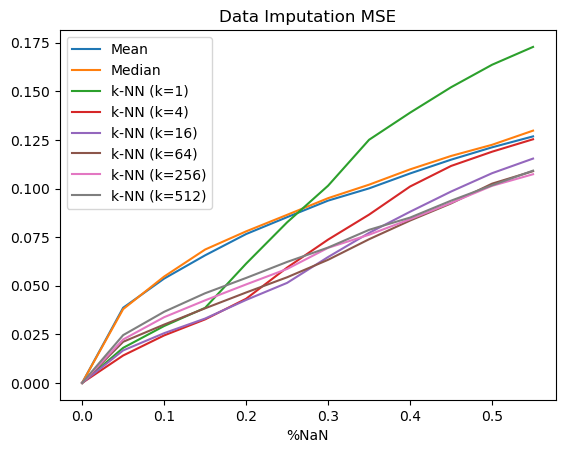

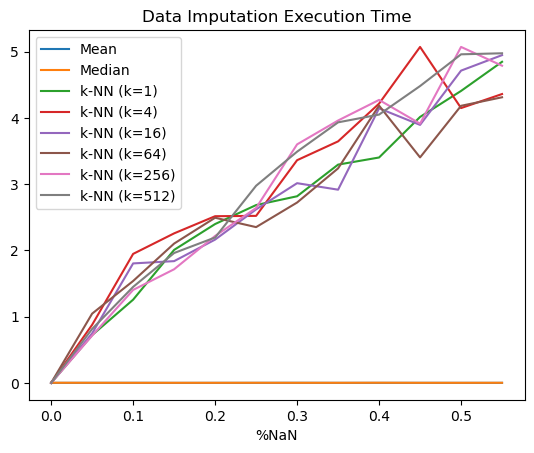

In [30]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(1), "k-NN (k=1)"),
    #(imputation_knn(2), "k-NN (k=2)"),
    (imputation_knn(4), "k-NN (k=4)"),
    #(imputation_knn(8), "k-NN (k=8)"),
    (imputation_knn(16), "k-NN (k=16)"),
    #(imputation_knn(32), "k-NN (k=32)"),
    (imputation_knn(64), "k-NN (k=64)"),
    #(imputation_knn(128), "k-NN (k=128)"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(512), "k-NN (k=512)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.038923,0.038413,0.023823,0.022519,0.024292,0.023836,0.023833,0.025715
0.10,0.054788,0.054865,0.034281,0.033932,0.033865,0.034764,0.033139,0.036754
0.15,0.066537,0.067600,0.042369,0.043829,0.043008,0.042295,0.043147,0.046153
0.20,0.076681,0.078222,0.051294,0.050333,0.052471,0.050040,0.051328,0.054301
0.25,0.085695,0.087159,0.059798,0.060108,0.059109,0.059888,0.059769,0.063140
0.30,0.093265,0.095624,0.067559,0.068008,0.067918,0.068015,0.066464,0.070193
0.35,0.101773,0.102100,0.076378,0.075438,0.076177,0.076507,0.076478,0.077749
0.40,0.106685,0.110158,0.083973,0.084312,0.084371,0.084200,0.084288,0.085548


,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.001449,0.002168,0.001148,0.002702,0.001059,0.001042,0.001449,0.001061
0.05,0.002329,0.002960,1.208918,0.898095,0.870378,0.858746,0.829420,0.967122
0.10,0.002256,0.002969,1.671950,1.469308,1.366239,1.456914,1.437222,1.351290
0.15,0.004570,0.002824,2.010112,1.859295,1.879424,1.792995,1.725258,1.924630
0.20,0.001903,0.004215,2.307069,2.564525,2.091031,2.121886,2.199031,2.179437
0.25,0.002819,0.002942,2.573356,2.597144,2.686614,2.707135,2.644647,2.950889
0.30,0.002170,0.003054,3.034800,2.893769,3.099917,2.739510,2.872970,2.951544
0.35,0.013749,0.002920,3.270075,3.447293,3.254218,3.470251,3.170469,3.494247
0.40,0.002384,0.003379,3.668530,3.466881,3.525314,3.882484,3.405764,3.531153


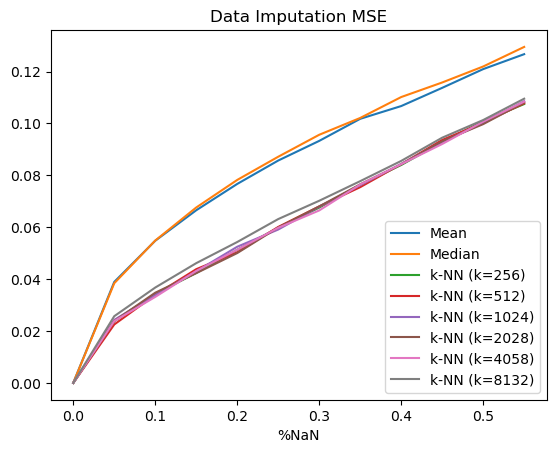

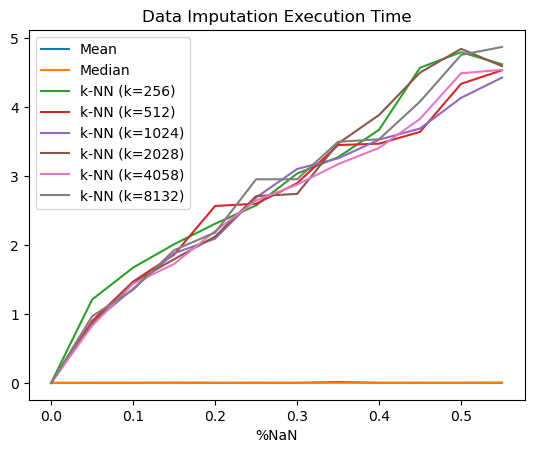

In [31]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(256), "k-NN (k=512)"),
    (imputation_knn(256), "k-NN (k=1024)"),
    (imputation_knn(256), "k-NN (k=2028)"),
    (imputation_knn(256), "k-NN (k=4058)"),
    (imputation_knn(512), "k-NN (k=8132)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

K-NN with k=4 and k=16 result in the lowest MSE for a dataset with less than 50% missing data! If time matters, simply using the mean is definitely the best choice!

/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [Ite

,Mean,Median,k-NN (k=16),MICE
%NaN,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.05,0.038768,0.038833,0.016997,0.022353
0.10,0.054113,0.055392,0.027074,0.031339
0.15,0.065163,0.068134,0.032852,0.042029
0.20,0.076553,0.077483,0.041771,0.048677
0.25,0.085160,0.087020,0.053938,0.056135
0.30,0.093398,0.094887,0.065406,0.070445
0.35,0.102205,0.102249,0.076521,0.077330
0.40,0.108111,0.109887,0.087839,0.083404


,Mean,Median,k-NN (k=16),MICE
%NaN,,,,
0.00,0.002568,0.003019,0.001126,0.064417
0.05,0.001800,0.003133,1.119491,2.714604
0.10,0.002036,0.003916,1.413674,3.944090
0.15,0.001711,0.006689,1.849205,3.372126
0.20,0.001688,0.003883,2.202349,3.487636
0.25,0.009401,0.002949,2.874789,3.482668
0.30,0.002241,0.005974,2.994080,3.006851
0.35,0.002117,0.003091,3.164978,4.010890
0.40,0.002078,0.002665,3.384076,2.912315


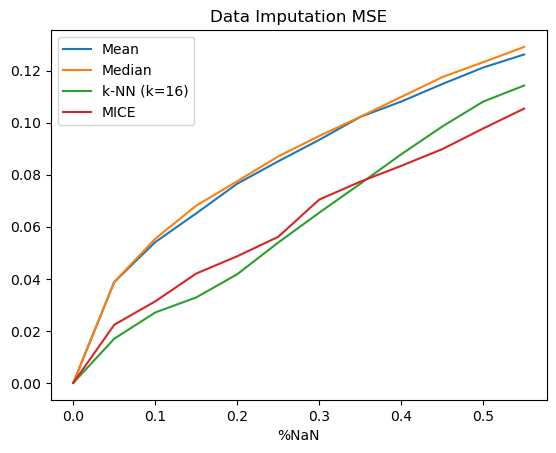

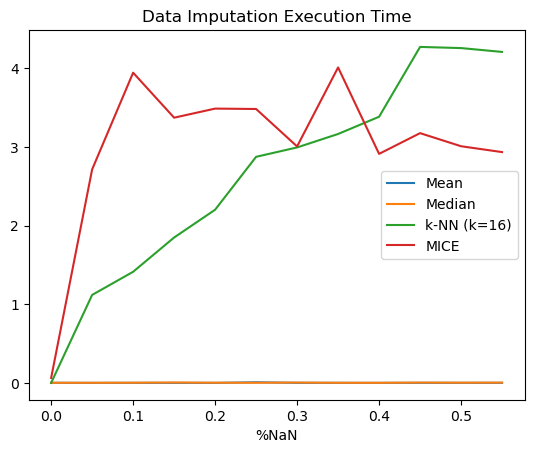

In [32]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(16), "k-NN (k=16)"),
    (imputation_mice, "MICE")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

# RESULT:
- k-NN and MICE increase the precision of the imputation
- The MSE of k-NN is about the half the mean-MSE.
- Performance of mean and median is almost the same, mean is slightly better on high % of NaN.
- Since mean and median are significantly faster than k-NN and MICE, we will use mean!


# Questions /TODOs
- Should I also test it on bigger datasets?
- It seems like the MSE is tiny for all methods. Is this the correct interpretation?
- The data is normalized to 0-1. A MSE of 0.1 means that the imputed values in average differ by 10% of the true value. Is this correct?